In [1]:
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf
%matplotlib inline

# Watermark is not required for this code, but is included for information. 
import watermark
%load_ext watermark
%watermark -a "ELEANOR LUTZ" -d -v -iv -m

numpy                           1.15.4
watermark                       1.8.1
matplotlib                      3.0.3
matplotlib.backends.backend_pdf 3.0.3
cartopy                         0.17.0
ELEANOR LUTZ 2019-07-07 

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
CPU cores  : 12
interpreter: 64bit


In [2]:
# Define variables used across all maps (size, color, projection center points)

figsize = (19.53/2, 18.55/2)
figsize_small = (9.235*(835/5536), 9.235*(835/5536))

ortho = [330, 30]
ortho_opp = [150, 0]
ortho_small = [60, 30]
ortho_n = [330, 90]
ortho_s = [330, -90]

linecolor = '#10112d'
oceancolor = '#277373'
landcolor = '#b6a765'

In [3]:
# Define function to save images in a standardized way 

def set_save_image(fig, savename, dpi=600, show=False):
    # Output text as editable PDF text objects instead of shapes
    matplotlib.rcParams['pdf.fonttype'] = 42
    
    # Force PDF to respect zorder by supressing image compositing
    matplotlib.rcParams['image.composite_image'] = False

    # Remove borders on the plot axes
    for ax in fig.get_axes():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_global()
        ax.background_patch.set_fill(False)
        ax.outline_patch.set_edgecolor('none')
        
    # Remove all padding and margins
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(matplotlib.pyplot.NullLocator())
    plt.gca().yaxis.set_major_locator(matplotlib.pyplot.NullLocator())
        
    if savename.split('.')[-1] == 'pdf':
        pp = pdf.PdfPages(savename, keep_empty=False)
        pp.savefig(fig)
        pp.close()
    elif savename.split('.')[-1] == 'png':
        plt.savefig(savename, format='png', dpi=dpi, pad_inches=0, transparent=True)
    else:
        print("Unrecognized file format, plot not saved!")

    if show == True: 
        plt.show()
    plt.clf()
    plt.close('all')

In [4]:
# Coastline vectors (all maps)

savenames = {'./figures/coastlines.png': [ortho, figsize, '50m', 1],
             './figures/coastlines_n.png': [ortho_n, figsize_small, '110m', 0.5],
             './figures/coastlines_s.png': [ortho_s, figsize_small, '110m', 0.5],
             './figures/coastlines_opp.png': [ortho_opp, figsize_small, '110m', 0.5],
             './figures/coastlines_small.png': [ortho_small, figsize_small, '110m', 0.5]}

for savename, value in savenames.items():
    orth = value[0]
    size = value[1]
    fig = plt.figure(figsize=size)
    ax = plt.axes(projection=ccrs.Orthographic(*orth))
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='coastline',
                                scale=value[2], edgecolor='k', facecolor='none',
                                linewidth=value[3], joinstyle='round'))
    
    set_save_image(fig, savename, show=False)

In [5]:
# Solid colors to separate land masses from oceans (all maps)

savenames = {'./figures/ocean': [ortho, figsize, '50m'],
             './figures/ocean_n': [ortho_n, figsize_small, '110m'],
             './figures/ocean_opp': [ortho_opp, figsize_small, '110m'],
             './figures/ocean_s': [ortho_s, figsize_small, '110m'] }

for savename, value in savenames.items():
    for b in ["", "noland"]:
        orth = value[0]
        size = value[1]
        scale = value[2]
        fig = plt.figure(figsize=size)
        ax = plt.axes(projection=ccrs.Orthographic(*orth))

        ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='ocean',
                                    scale=scale, facecolor=oceancolor))
        if b == "":
            ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='land',
                                    scale=scale, facecolor=landcolor))
        set_save_image(fig, savename+b+".png", show=False)

In [6]:
# PLOT RIVER AND LAKE CENTER VECTORS

fname = "./data/Natural_Earth/ne_10m_rivers_lake_centerlines/ne_10m_rivers_lake_centerlines.shp"
savename = './figures/rivers_lakes.png'
shp = shpreader.Reader(fname)

fig = plt.figure(figsize=figsize)
ax = plt.axes(projection=ccrs.Orthographic(*ortho))

for record, state in zip(shp.records(), shp.geometries()):
    alpha = min(1, max(0, (11-record.attributes['scalerank'])/11))
    ax.add_geometries([state], ccrs.PlateCarree(), facecolor='none', 
                      edgecolor=oceancolor, lw=0.5, alpha=alpha)

set_save_image(fig, savename, show=False)

In [7]:
# READ IN TECTONIC PLATE VECTORS AND PLOT

fname = "./data/USGS_plate_boundaries/Plate_Boundaries.shp"
shp = shpreader.Reader(fname)

savenames = {'./figures/tectonic.png': [ortho, figsize],
             './figures/tectonic_n.png': [ortho_n, figsize_small],
             './figures/tectonic_opp.png': [ortho_opp, figsize_small],
             './figures/tectonic_s.png': [ortho_s, figsize_small] }

for savename, value in savenames.items():
    orth = value[0]
    size = value[1]
    fig = plt.figure(figsize=size)
    ax = plt.axes(projection=ccrs.Orthographic(*orth))

    if size == figsize: 
        lw = 1
    else: 
        lw = 0.25
        
    for record, state in zip(shp.records(), shp.geometries()):
        ax.add_geometries([state], ccrs.PlateCarree(), facecolor='none', edgecolor=linecolor, lw=lw)

    set_save_image(fig, savename, show=False)

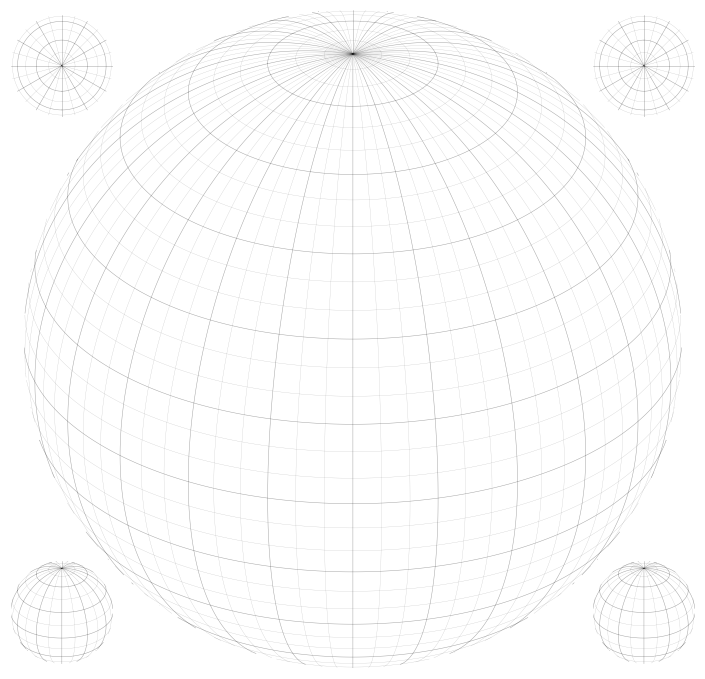

In [8]:
# Plot gridlines for orthographic map

savename = './figures/ortho_gridlines.png'
figsize = (19.53/2, 18.55/2)
north = [0, 90]
south = [0, -90]

fig = plt.figure(figsize=figsize)
grid = matplotlib.gridspec.GridSpec(5565, 5859)
ax = fig.add_subplot(grid[39:5565-39, 186:5859-186], projection=ccrs.Orthographic(90, 30))
ax1 = fig.add_subplot(grid[78:852+78, 78:852+78], projection=ccrs.Orthographic(*north))
ax2 = fig.add_subplot(grid[78:852+78, 5859-78-852:5859-78], projection=ccrs.Orthographic(*south))
ax3 = fig.add_subplot(grid[5565-78-852:5565-78, 78:852+78], projection=ccrs.Orthographic(90, 30))
ax4 = fig.add_subplot(grid[5565-78-852:5565-78, 5859-78-852:5859-78], projection=ccrs.Orthographic(90, 30))
    
lon_large = np.arange(0, 360, 30)
lon_small = np.arange(0, 360, 15)
lon_mini = np.arange(0, 360, 5)
lat_large = np.arange(-90, 91, 30)
lat_small = np.arange(-90, 91, 15)
lat_mini = np.arange(-90, 91, 5)
lat_delim = np.arange(-90, 90.01, 0.1)
lon_delim = np.arange(0, 360, 0.1)

for a in [ax1, ax2, ax3, ax4]:
    for lg in lat_large: 
        a.plot(lon_delim, [lg]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)
    for sm in lat_small: 
        if sm not in lat_large: 
            a.plot(lon_delim, [sm]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.25, alpha=0.25)
    for lg in lon_large: 
        a.plot([lg]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)
    for sm in lon_small: 
        if sm not in lon_large: 
            a.plot([sm]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), color='k', lw=0.25, alpha=0.25)

for lg in lat_small: 
    ax.plot(lon_delim, [lg]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)
for sm in lat_mini: 
    if sm not in lat_small: 
        ax.plot(lon_delim, [sm]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.25, alpha=0.25)
for lg in lon_small: 
    ax.plot([lg]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)
for sm in lon_mini: 
    if sm not in lon_small: 
        ax.plot([sm]*len(lat_delim), lat_delim, transform=ccrs.PlateCarree(), color='k', lw=0.25, alpha=0.25)

set_save_image(fig, savename, show=True)

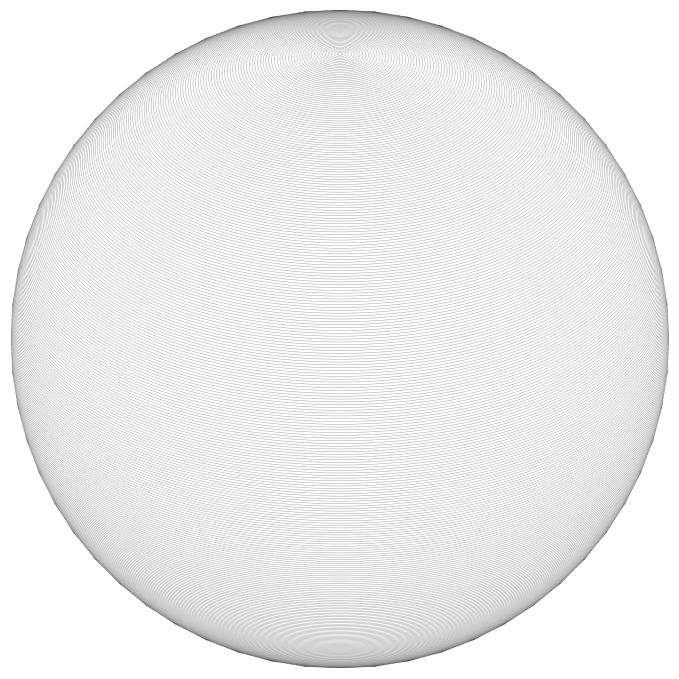

In [9]:
# Plot gridlines for orthographic map labels (to type text onto in Illustrator)

savename = './figures/ortho_gridlines_labels.pdf'

fig = plt.figure(figsize=figsize)
grid = matplotlib.gridspec.GridSpec(5565, 5859)
ax = fig.add_subplot(grid[39:5565-39, 186:5859-186], projection=ccrs.Orthographic(90, 30))

lat_small = np.arange(-90, 91, 0.5)
lon_delim = np.arange(0, 360, 0.1)

for lg in lat_small: 
    ax.plot(lon_delim, [lg]*len(lon_delim), transform=ccrs.PlateCarree(), color='k', lw=0.5, alpha=0.35)

set_save_image(fig, savename, show=True)